In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import os
import warnings

warnings.filterwarnings('ignore')

데이터 로드

In [2]:
train = pd.read_csv('train.csv')
train.drop('id', inplace = True, axis=1)
test = pd.read_csv('test.csv')
test.drop('id', inplace = True, axis=1)
sample_submission = pd.read_csv('sample_submission.csv')

#  EDA

#### 데이터의 수

In [3]:
print(f"train : {train.shape}")
print(f"test : {test.shape}")

train : (1253, 9)
test : (2924, 8)


test 데이터가 트레인 데이터에 비해서 많은 row의 수를 보입니다. 좀 더 일반화된 결과를 내야할 것 같습니다.

#### 데이터 타입

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          1253 non-null   object 
 1   Lenght          1253 non-null   float64
 2   Diameter        1253 non-null   float64
 3   Height          1253 non-null   float64
 4   Whole Weight    1253 non-null   float64
 5   Shucked Weight  1253 non-null   float64
 6   Viscra Weight   1253 non-null   float64
 7   Shell Weight    1253 non-null   float64
 8   Target          1253 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 88.2+ KB


category데이터 타입인 gender열을 제외한다면 모도 연속형변수입니다

#### 값

In [5]:
train.describe()

Lenght     Diameter       Height  Whole Weight  Shucked Weight  \
count  1253.000000  1253.000000  1253.000000   1253.000000     1253.000000   
mean      0.522869     0.406963     0.139545      0.831199        0.358818   
std       0.120231     0.099771     0.039033      0.500491        0.224612   
min       0.110000     0.090000     0.030000      0.008000        0.002500   
25%       0.445000     0.345000     0.115000      0.440500        0.182500   
50%       0.535000     0.420000     0.140000      0.777500        0.326000   
75%       0.615000     0.480000     0.165000      1.160000        0.505500   
max       0.780000     0.630000     0.250000      2.779500        1.488000   

       Viscra Weight  Shell Weight       Target  
count    1253.000000   1253.000000  1253.000000  
mean        0.181006      0.240077     9.912211  
std         0.111936      0.142574     3.214676  
min         0.002000      0.003000     3.000000  
25%         0.092500      0.130000     8.000000  
50%         0.168000      0.230000    10.000000  
75%         0.256500      0.330000    11.000000  
max         0.760000      1.005000    29.000000

####  결측값 확인

In [6]:
def check_missing_values(df):
    missing_values = df.isnull().sum().sort_values(ascending = False)
    percentage_missing_values = (missing_values/len(df))*100
    result = pd.concat([missing_values, percentage_missing_values], axis = 1, keys= ['Missing values', '% Missing'])
    display(result)

check_missing_values(train)

Missing values  % Missing
Gender                       0        0.0
Lenght                       0        0.0
Diameter                     0        0.0
Height                       0        0.0
Whole Weight                 0        0.0
Shucked Weight               0        0.0
Viscra Weight                0        0.0
Shell Weight                 0        0.0
Target                       0        0.0

결측값은 어느 feature에도 보이지 않습니다.

####  데이터 분포확인

Index(['Lenght', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight',
       'Viscra Weight', 'Shell Weight', 'Target'],
      dtype='object')


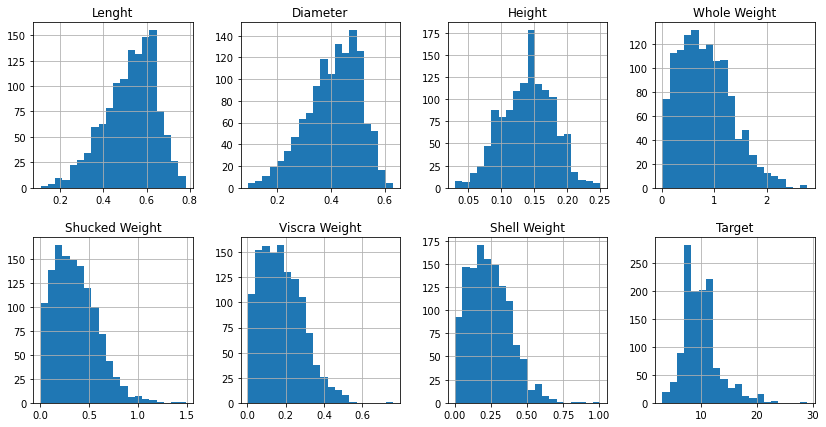

In [7]:
plot_cols_list = train.columns[1:]
print(plot_cols_list)

train[plot_cols_list].hist(figsize=(14,7), grid = True, layout = (2,4), bins = 20)
plt.show()

#### 상관관계확인

Lenght  Diameter    Height  Whole Weight  Shucked Weight  \
Lenght          1.000000  0.987293  0.901911      0.926321        0.896337   
Diameter        0.987293  1.000000  0.908348      0.927205        0.891183   
Height          0.901911  0.908348  1.000000      0.895409        0.837456   
Whole Weight    0.926321  0.927205  0.895409      1.000000        0.968007   
Shucked Weight  0.896337  0.891183  0.837456      0.968007        1.000000   
Viscra Weight   0.903732  0.901029  0.868192      0.966942        0.932138   
Shell Weight    0.895664  0.904546  0.902180      0.951652        0.870453   
Target          0.543789  0.567933  0.604654      0.538404        0.420126   

                Viscra Weight  Shell Weight    Target  
Lenght               0.903732      0.895664  0.543789  
Diameter             0.901029      0.904546  0.567933  
Height               0.868192      0.902180  0.604654  
Whole Weight         0.966942      0.951652  0.538404  
Shucked Weight       0.932138      0.870453  0.420126  
Viscra Weight        1.000000      0.905061  0.497283  
Shell Weight         0.905061      1.000000  0.625819  
Target               0.497283      0.625819  1.000000

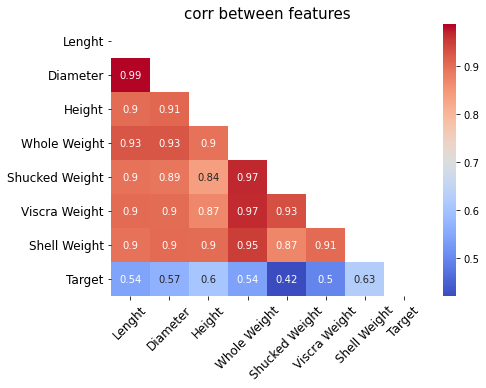

In [8]:
def corr_heat(df):
    plt.figure(figsize=(7,5))

    corr_df = df.corr()
    display(corr_df)

    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = 1
    heat_map = sns.heatmap(corr_df, annot=True, mask = mask, cmap='coolwarm')
    heat_map.set_xticklabels(heat_map.get_xticklabels(), fontsize=12, rotation=45)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), fontsize=12)
    plt.title('corr between features', fontsize=15)
    plt.show()
    
corr_heat(train[plot_cols_list])

연속형 변수끼리 모두 높은 상관관계를 보입니다. 값들이 비슷한 양상을 보일것으로 예상되기 때문에 다른 수치형 학습방법보다는 트리기반 모델이 어울릴 것으로 예상됩니다

<AxesSubplot:>

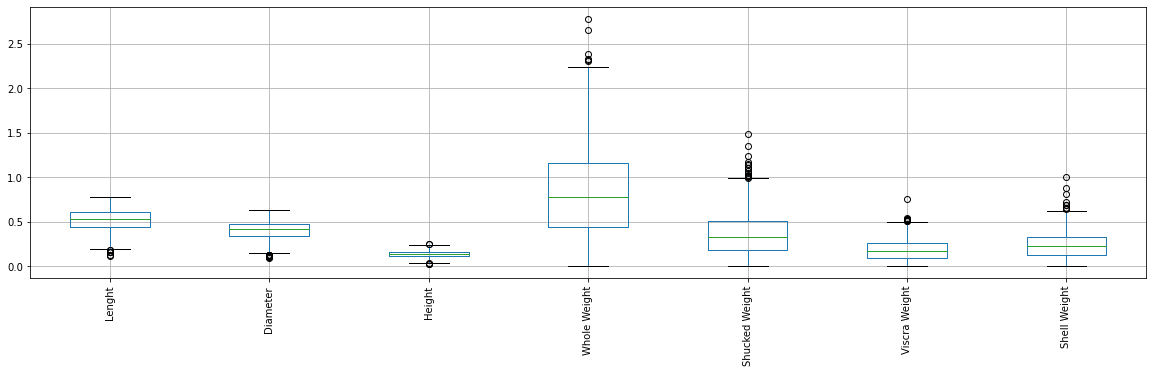

In [9]:
train[plot_cols_list[:-1]].boxplot(rot = 90, figsize=(20,5))

큰 특징이 보이지는 않습니다

#### gender 변수 값에 따른 값확인

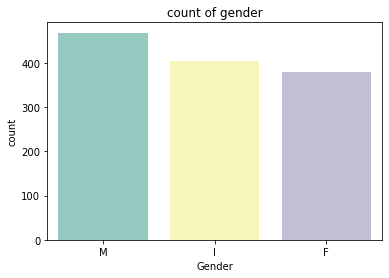

In [10]:
sns.countplot(x = 'Gender', data = train, palette="Set3")
plt.title('count of gender')
plt.show()

유일한 category변수인 성별 변수입니다. 수가 조금씩 다르기 때문에 학습시에 편향되지않게 학습데이터와 평가데이터를 나누어야 할 것 같습니다.

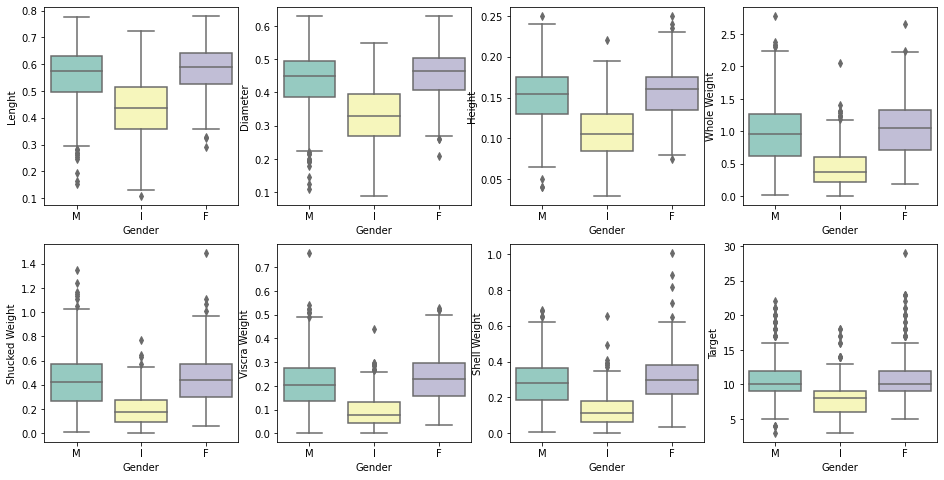

In [11]:
fig = plt.figure(figsize=(16,8))

for i,col in enumerate(plot_cols_list):
    fig.add_subplot(2,4,i+1)
    sns.boxplot(x="Gender", y=col, data=train, palette="Set3")
    # plt.title(f'{col}')

I라는 성별이 모든 변수에서 전체적인 값이 낮은 것으로 보여집니다. 학습시에 I를 따로 모델을 만들 가능성을 열어두어야겠습니다.

이상값은 크게 주목할 것이 없을 것 같습니다.

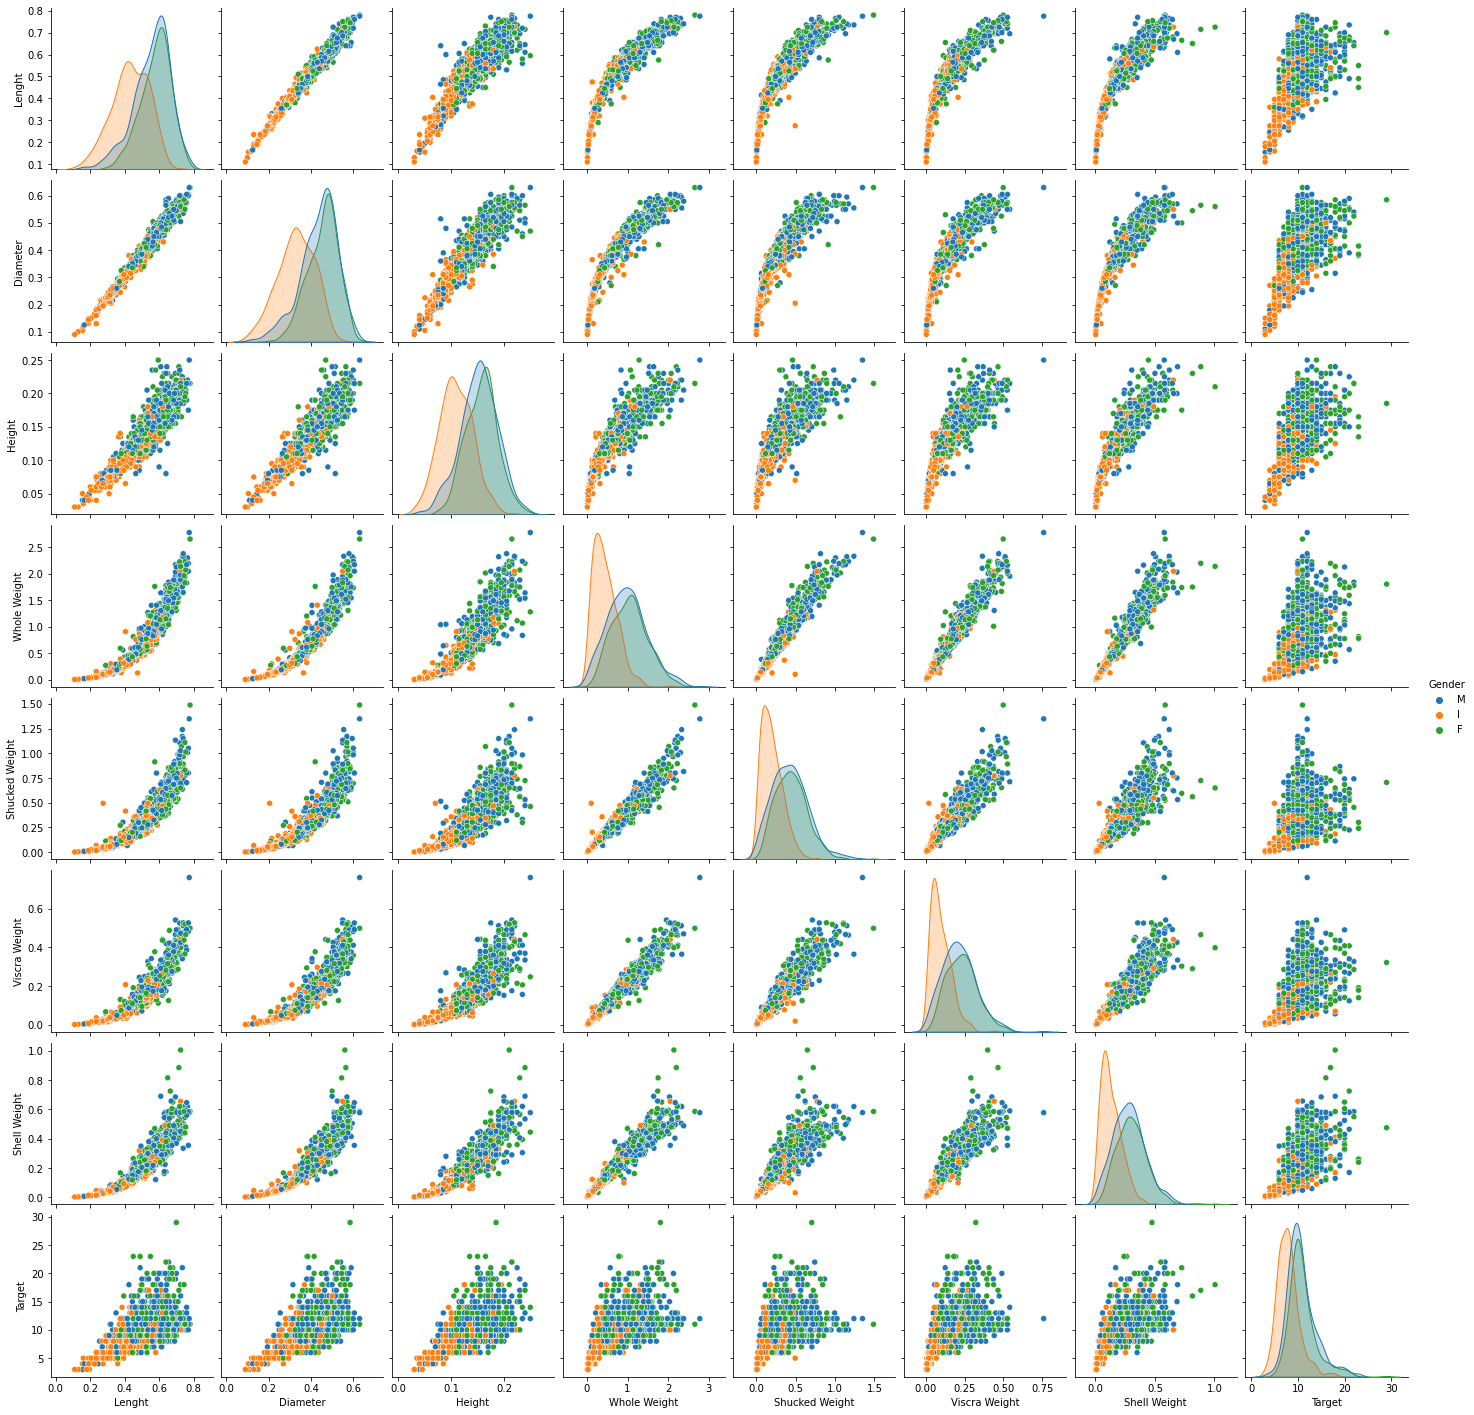

In [12]:
sns.pairplot(train[list(plot_cols_list)+['Gender']], hue="Gender")

# 모델링

In [13]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['Gender'])
gender_encoded_train = encoder.transform(train['Gender'])
gender_encoded_test = encoder.transform(test['Gender'])
train['Gender'] = gender_encoded_train
test['Gender'] = gender_encoded_test

X = train.drop('Target', axis=1)
y = train['Target']

학습을 위해 라벨인코딩을 실시했습니다. category의 처리는 lgbm의 내장기능을 이용할 것이기때문에 원핫인코딩은 추가로 진행하지 않습니다

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=722)
skf.split(X, X['Gender'])

pred_list = []
mae_list = []

for fold,(train_index, val_index) in enumerate(skf.split(X,  X['Gender'])):

    print(f'***********{fold+1}th fold start***********')
    x_train, x_val, y_train, y_val = X.loc[train_index], X.loc[val_index], y.loc[train_index], y.loc[val_index]

    lgb = lightgbm.LGBMRegressor(boosting_type='gbdt',
        n_estimators=1000, random_state=722, learning_rate=0.05, categorical_feature=[0])

    lgb.fit(x_train, y_train,
            eval_set=(x_val,y_val),
            eval_metric='l1', verbose=False, early_stopping_rounds=100)

    pred = lgb.predict(x_val)
    result = mean_absolute_error(pred,y_val)
    mae_list.append(result)
    
    pred_test = lgb.predict(test)
    pred_list.append(pred_test)
    
    print(f'mae : {result:.4f}', end='\n\n')
    
print(f'mean mae {np.mean(mae_list):.4f}')

***********1th fold start***********
mae : 1.5864

***********2th fold start***********
mae : 1.5426

***********3th fold start***********
mae : 1.4702

***********4th fold start***********
mae : 1.4828

***********5th fold start***********
mae : 1.8582

mean mae 1.5880


5개의 폴드로 학습진행했습니다. 일단 loss는 mae로 진행하였고, 학습과 평가데이터 셋간의 gender의 비율이 유지되게끔 StratifiedKFold를 이용했습니다.

In [15]:
# sample_submission['Target'] = np.mean(pred_list,axis=0)
# sample_submission.to_csv('try3.csv', index=False)

5 폴드의 학습 모델마다 test셋에 대해 예측을 실시하고 평균을 내에 제출했습니다.

###### 아직 파생변수와 파라미터 튜닝을 하지 않은 상태이기 때문에 더 나아갈 부분이 많이 보입니다. 추가로 다른 성별에 비해서 i성별의 모든 특성의 분포가 낮은 것을 확인했기때문에 i성별을 따로 모델링한다면 어떤 결과가 나올지 확인해 볼 예정입니다.